In [1]:
pip install tinkoff-investments

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as pdr
import csv

from datetime import date
from tinkoff.invest import CandleInterval, Client, InstrumentStatus
from tinkoff.invest.services import InstrumentsService, MarketDataService
from tinkoff.invest.schemas import CandleSource
from tinkoff.invest.utils import now
from datetime import timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf




In [5]:
TOKEN = "t.h4d5TSQa5bCYYIuLngkOL_exhWhUMxxH8WriKm3YKFdE5_U70d5LnRRG04shjnijR5gczdmb6Yq2SSCkgzutFQ"

In [88]:
with Client(TOKEN) as client:
    with open('data.csv', mode='w', newline='') as file:
        fieldnames = ['Close']  # Заголовки столбцов
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        
        for candle in client.get_all_candles(
            instrument_id="BBG004RVFFC0",
            from_=now() - timedelta(days=2000),
            interval=CandleInterval.CANDLE_INTERVAL_DAY,
            candle_source_type=CandleSource.CANDLE_SOURCE_UNSPECIFIED,
        ):
            cand = candle.close.units
            writer.writerow({'Close': cand})

In [89]:
data_closed = pd.read_csv('data.csv')
print(data_closed)

      Close
0       726
1       705
2       705
3       725
4       714
...     ...
1360    721
1361    728
1362    729
1363    731
1364    739

[1365 rows x 1 columns]


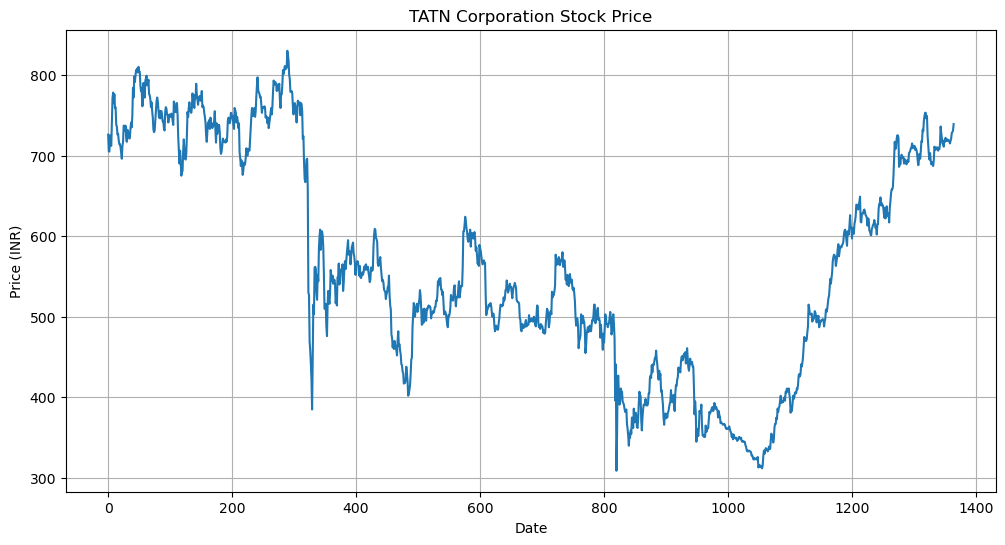

In [90]:
plt.figure(figsize=(12, 6))
plt.plot(data_closed['Close'])
plt.title("TATN Corporation Stock Price")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.grid(True)
plt.show()

In [91]:
train = pd.DataFrame(data_closed[0:int(len(data_closed))])
# test = pd.DataFrame(data_closed[int(len(data_closed)*0.70): int(len(data_closed))])

print(train)
# print(test.shape)

      Close
0       726
1       705
2       705
3       725
4       714
...     ...
1360    721
1361    728
1362    729
1363    731
1364    739

[1365 rows x 1 columns]


In [92]:
# Делаем нормализацию данных
scaler = MinMaxScaler()
data_closed_scaled = pd.DataFrame(scaler.fit_transform(data_closed), columns=data_closed.columns) # применяем скалирование

In [94]:
data_closed_scaled

,Close
0,0.800384
1,0.760077
2,0.760077
3,0.798464
4,0.777351
...,...
1360,0.790787
1361,0.804223
1362,0.806142
1363,0.809981


In [95]:
# Выделяем сегмент для тренировки сети и сегмент для тестирования натренированной сети в отношении 1/4
train, test = train_test_split(data_closed_scaled, test_size=0.2, shuffle=False)

In [96]:
print(train.head())
print(test.head())

      Close
0  0.800384
1  0.760077
2  0.760077
3  0.798464
4  0.777351
         Close
1092  0.166987
1093  0.188100
1094  0.186180
1095  0.195777
1096  0.190019


In [97]:
# Определяем структуру нашей модели
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(None, 1))) # Первый слой - это LSTM сеть
model.add(Dense(1)) # второй слой - обычная линейная регрессия
model.compile(optimizer='adam', loss='mean_squared_error') # в качестве метода оптимизации используем стохастический градиентный метод, в качестве целевой функции среднюю квадратичную ошибку

D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [98]:
# Готовим данные для обучения сети
window_size = 10  # Выбираем размер окна для формирования предсказания
X_train = np.array([train.iloc[i-window_size:i].values for i in range(window_size, len(train))])
y_train = train.iloc[window_size:, 0].values
X_test = np.array([test.iloc[i-window_size:i].values for i in range(window_size, len(test))])
y_test = test.iloc[window_size:, 0].values
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

In [99]:
print(train[:31])
print(X_train[0])
print(X_train[1])
print(y_train)

       Close
0   0.800384
1   0.760077
2   0.760077
3   0.798464
4   0.777351
5   0.773512
6   0.833013
7   0.886756
8   0.900192
9   0.875240
10  0.896353
11  0.863724
12  0.865643
13  0.823417
14  0.819578
15  0.800384
16  0.802303
17  0.786948
18  0.777351
19  0.777351
20  0.769674
21  0.756238
22  0.742802
23  0.773512
24  0.783109
25  0.821497
26  0.821497
27  0.809981
28  0.821497
29  0.794626
30  0.783109
[[0.80038388]
 [0.76007678]
 [0.76007678]
 [0.79846449]
 [0.77735125]
 [0.77351248]
 [0.83301344]
 [0.88675624]
 [0.90019194]
 [0.87523992]]
[[0.76007678]
 [0.76007678]
 [0.79846449]
 [0.77735125]
 [0.77351248]
 [0.83301344]
 [0.88675624]
 [0.90019194]
 [0.87523992]
 [0.89635317]]
[0.89635317 0.86372361 0.86564299 ... 0.16314779 0.17274472 0.17466411]


In [100]:
data_closed_scaled

,Close
0,0.800384
1,0.760077
2,0.760077
3,0.798464
4,0.777351
...,...
1360,0.790787
1361,0.804223
1362,0.806142
1363,0.809981


In [101]:
# Обучаем модель
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1921 - val_loss: 0.0086
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107 - val_loss: 0.0018
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 9.0779e-04
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 6.6751e-04
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

In [83]:
# Вычисляем отклонение по целевой функции
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7252e-04 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5900e-04 
Train Loss: 0.0008110032067634165
Test Loss: 0.0005645405617542565


In [120]:
# Делаем прогноз
print("Getting recent data...")

# Формируем данные для входа сети - забираем с хвоста 11 значений и удаляем послденее, полученный массив приводим к формату входа сети (1,10,1)
recent_data = np.resize(np.array(data_closed_scaled['Close'].tail(window_size + 1)), window_size).reshape(1, window_size, 1)
print("Making prediction...")

# Делаем прогноз следующего значения
predicted_value_scaled = model.predict(recent_data)
print("Reversing scaling...")

# Преобразуем нормализованный прогноз в исходное значение
predicted_value = scaler.inverse_transform(predicted_value_scaled)
print("=========")
print(predicted_value)
print("=========")

# Сравниваем с известным значением - последним значением исходной выборки
actual_value = np.array(data_closed['Close'].iloc[-1]).reshape(-1,1)

# Добавляем прогноз к предыдущим данным
all_data = np.append(data_closed['Close'][:-1], predicted_value)

# Удаляем первое значение из всех данных
all_data = all_data[1:]

# Преобразуем обратно в исходное значение
pred = all_data[-1]
actual = actual_value[0][0]
print("Predicted temperature: ", pred)
print("Actual temperature: ", actual)


Getting recent data...
Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Reversing scaling...
[[730.0496]]
Predicted temperature:  730.0496215820312
Actual temperature:  739


In [118]:
data_closed_scaled.shape

(1365, 1)